In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
path = '../data/noise_removal'
train_path = f'{path}/train'
train_cleaned_path = f'{path}/train_cleaned'
test_path = f'{path}/test'

In [3]:
train_img = sorted(os.listdir(train_path))
train_cleaned_img = sorted(os.listdir(train_cleaned_path))
test_img = sorted(os.listdir(test_path))

In [4]:
def process_image(path):

    image = cv2.imread(path)
    image = np.asarray(image, dtype="float32")
    image = cv2.resize(image, (540, 420))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image / 255.0
    image = np.reshape(image, (420, 540, 1))

    return image

def process_image_folder(folder_path):

    folder_images = sorted(os.listdir(folder_path))

    process_images = [
        process_image(folder_path + f'/{image}')
        for image in tqdm(folder_images)
    ]

    return process_images

In [5]:
train = process_image_folder(train_path)
train_cleaned = process_image_folder(train_cleaned_path)
test = process_image_folder(test_path)

100%|██████████| 72/72 [00:00<00:00, 154.90it/s]


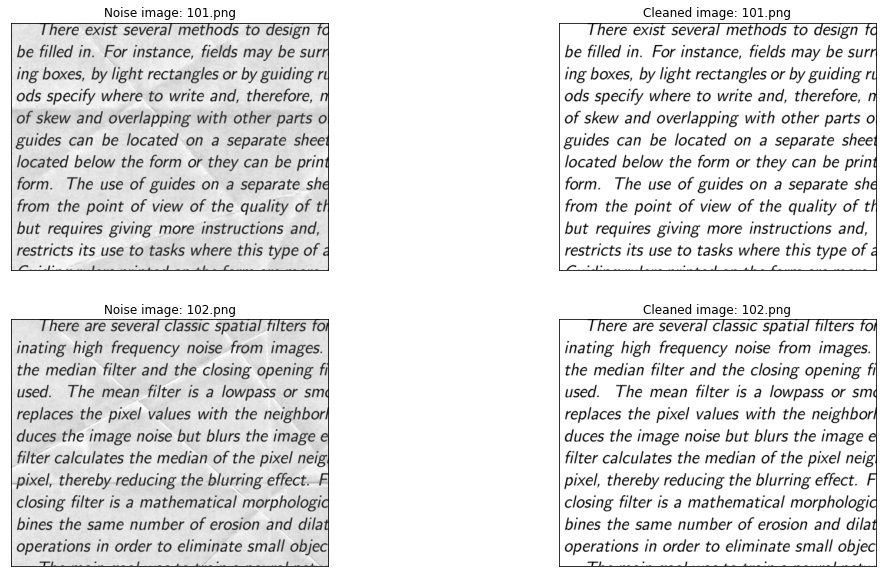

In [7]:
nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))

image_idx = 0
for i in range(nrows):
    for j in range(ncols):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        if j == 1:
            ax[i,j].imshow(train_cleaned[image_idx][:,:,0], cmap='gray')
            ax[i,j].set_title('Cleaned image: {}'.format(train_img[i]))
        else:
            ax[i,j].imshow(train[image_idx][:,:,0], cmap='gray')
            ax[i,j].set_title('Noise image: {}'.format(train_img[i]))

    image_idx += 1

In [8]:
X_train = np.asarray(train)
y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [9]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((122, 420, 540, 1), (22, 420, 540, 1), (122, 420, 540, 1), (22, 420, 540, 1))

In [10]:
def encoder(input_layer):

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Dropout(0.5)(x)

    return x

def decoder(x):

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    output_layer = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return output_layer

def auto_encoder(input_shape=(420, 540, 1)):

    input_layer = tf.keras.layers.Input(shape=input_shape)

    x = encoder(input_layer)
    output_layer = decoder(x)

    model = tf.keras.models.Model(
        inputs=[input_layer],
        outputs=[output_layer]
    )
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

In [11]:
model = auto_encoder()

2021-11-15 19:31:07.506436: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 420, 540, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization (BatchN  (None, 420, 540, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 210, 270, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 210, 270, 128)     0     

In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=24,
    callbacks=[callback]
)

Epoch 1/100
2/6 [=========>....................] - ETA: 2:38 - loss: 0.1948 - mae: 0.3420